## **Identify Fraud From Enron Email**

The project uses the dataset from the Enron fraud case to create a predicitive model using machine learning algorithms to help pin point which employees could be a person of interest in the investigation based on financial and email records. 

In [318]:
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.metrics import accuracy_score 
from sklearn.metrics import precision_score 
from sklearn.metrics import recall_score 

sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data
from tester import test_classifier

**Feature Selection**

Below are my feature selections. I origionally included all finacial features, 'poi', and a few of the emial features. As you can see some have been commented out and I will explain why I chose those a bit later in the report. 

In [319]:
### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
features_list = ['poi','salary', 'deferral_payments', 
                 'total_payments', 'loan_advances', 
                 'bonus', 'restricted_stock_deferred', 
                 'deferred_income', 'total_stock_value', 
                 'expenses', 
                 'exercised_stock_options', 
                 'long_term_incentive', 
                 'restricted_stock',
                 'to_messages', 
                 'from_poi_to_this_person', 'from_messages',
                 'from_this_person_to_poi'
                 ]



In [320]:
### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)


**Data Exploration**

In this section I  will explore the dataset to get an idea of the data structure and what I was working with.

In [321]:
##Data Exploration
#total number of data points
total_people = len(data_dict.keys())

print 'Number of people:', total_people
print 'Number of features:',(len(data_dict.values()[0]))
##Finding POIs in the Enron Data
poi_count=0
for x, y in data_dict.items():
    if y['poi']==1:
        poi_count+=1
print 'Person of Interest count:', poi_count

#Percent POI
poi_perc = round((1.*poi_count/total_people)*100,2)
print 'POI percentage:',poi_perc,"%"

# # of features used
feat_len = len(features_list)
print 'Number of features used:', feat_len





Number of people: 146
Number of features: 21
Person of Interest count: 18
POI percentage: 12.33 %
Number of features used: 17


There are 146 observations with 23 features. Of the 145 observations, 23 are a 'Person of Interest', which amounted to 12.41% of observations as poi's. Of the 23 features, I chose to use 12 of them. 

**Outliers**

Below I will check the data for outliers based on salary and bonus, and remove them is needed. 

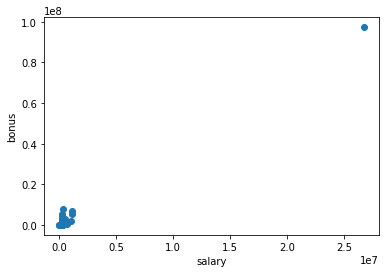

In [322]:
### Task 2: Remove outliers
##check for outliers
features = ['salary','bonus']
data = featureFormat(data_dict, features)

plt.scatter(data[:,0], data[:,1])
plt.xlabel("salary")
plt.ylabel("bonus")
plt.show()




As you can see in the scatter plot above, there are significant outliers that need to be removed.

Outliers left:
[('SKILLING JEFFREY K', 1111258), ('LAY KENNETH L', 1072321), ('FREVERT MARK A', 1060932), ('PICKERING MARK R', 655037)]


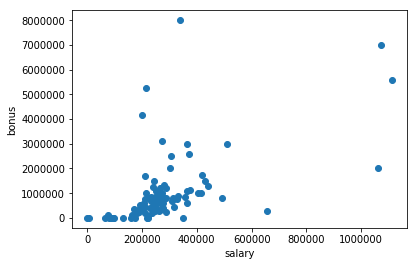

In [323]:
##Remove
data_dict.pop('TOTAL', 0)
data = featureFormat(data_dict, features)

person = [] 
for p in data_dict: 
     if data_dict[p]['salary'] != "NaN": 
         person.append((p, data_dict[p]['salary'])) 
print "Outliers left:" 
print sorted(person, key = lambda x: x[1], reverse=True)[0:4]

plt.scatter(data[:,0], data[:,1])
plt.xlabel("salary")
plt.ylabel("bonus")
plt.show()

After removing the outliers, I was able to get a better view of the data. There were still a couple of outliers iddentified as Jefferey Skilling, Kenneth Lay, and Mark Frevert but I chose to keep due to the fact that they were top exectuives and most likely involved in the fraud

**Features**

Below I create two new features that find a persons ratio of emails sent to and recieved from a person of interest. I believe these ratios would help see a person's interactions with a person of interest which may then reveal whether of not they themselves were involed in the fraud based on the level of activity. 

In [324]:
### Task 3: Create new feature(s)
### Store to my_dataset for easy export below.
my_dataset = data_dict
for p in my_dataset:
    from_poi = my_dataset[p]['from_poi_to_this_person']
    total_to_msg = my_dataset[p]['to_messages']
    if from_poi != 'NaN' and total_to_msg !='NaN':
        my_dataset[p]['from_poi_perc'] = (1.*from_poi/total_to_msg)*100
    else:
        my_dataset[p]['from_poi_perc'] = 0
        
for p in my_dataset:
    to_poi = my_dataset[p]['from_this_person_to_poi']
    total_from_msg = my_dataset[p]['from_messages']
    if to_poi != 'NaN' and total_from_msg !='NaN':
        my_dataset[p]['to_poi_perc'] = (1.*to_poi/total_from_msg)*100
    else:
        my_dataset[p]['to_poi_perc'] = 0

features_list = features_list + ['to_poi_perc']+['from_poi_perc']
features_list


['poi',
 'salary',
 'deferral_payments',
 'total_payments',
 'loan_advances',
 'bonus',
 'restricted_stock_deferred',
 'deferred_income',
 'total_stock_value',
 'expenses',
 'exercised_stock_options',
 'long_term_incentive',
 'restricted_stock',
 'to_messages',
 'from_poi_to_this_person',
 'from_messages',
 'from_this_person_to_poi',
 'to_poi_perc',
 'from_poi_perc']

I have added to new features to the features list. After running SelectKBest, shown below, the new feature 'to_poi_perc' was selected as one of the best features and will make a significant impact on final recall and precision score which is seen at the end of the report. 


In [325]:
### Extract features and labels from dataset for local testing
my_dataset = data_dict
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)


Earlier in the report I mentioned that I would explain why I chose to comment out certain features. My reasoning is based on the algorithm I ran below. I tested a number of different k values starting with the default of 10. 
Precision and Recall based on k-value:

k = 10: p = 0.32 , r = 0.31

k = 9: p = 0.40, r = 0.31

k = 8: p = 0.48, r = 0.39

k = 7: p = 0.48, r = 0.37

k = 6: p = 0.51, r = 0.38

k = 5: p = 0.48, r = 0.38

k = 4: p = 0.49, r = 0.32

K with a value of 5 gives the highest, balanced precision and recall and so that is I the value I will use.


In [326]:
features_list = ['poi',
 'salary',
 'deferral_payments',
 'total_payments',
 'loan_advances',
 'bonus',
 'restricted_stock_deferred',
 'deferred_income',
 'total_stock_value',
 'expenses',
 'exercised_stock_options',
 'long_term_incentive',
 'restricted_stock',
 'to_messages',
 'from_poi_to_this_person',
 'from_messages',
 'from_this_person_to_poi',
 'to_poi_perc',
 'from_poi_perc']
from sklearn.feature_selection import f_classif, SelectKBest 
k = 7
selector = SelectKBest(f_classif, k) 
selector.fit_transform(features, labels) 
print "Best features:"
scores = zip(features_list[1:],selector.scores_)
scores_sorted = sorted(scores, key = lambda x: x[1], reverse=True  )
#scores_sorted
best_features = scores_sorted[:k]
best_features

Best features:


[('exercised_stock_options', 25.097541528735491),
 ('total_stock_value', 24.467654047526398),
 ('bonus', 21.060001707536571),
 ('salary', 18.575703268041785),
 ('to_poi_perc', 16.641707070469028),
 ('deferred_income', 11.595547659730601),
 ('long_term_incentive', 10.072454529369441)]

To optimze my features chosen, I used the SelectKBest algorithm to identify the top seven best features in the dataset. Based off of the output, I adjusted the features I orgionally chose to use the optimal ones.

In [327]:
##Final set of features
features_list = ['poi','salary', #'deferral_payments', 
                 #'total_payments', 
                 #'loan_advances', 
                 'bonus', #'restricted_stock_deferred', 
                 'deferred_income', 
                 'total_stock_value', 
                 #'expenses', 
                 'exercised_stock_options',
                 'long_term_incentive',
                 #'restricted_stock',
                 #'to_messages', 
                 #'from_poi_to_this_person', 'from_messages',
                 #'from_this_person_to_poi'
                 'to_poi_perc'
                 #'from_poi_perc'
                 ]
                 

**Validation**

Validation is a procoess of model performance evaluation. The purpose of it is to make sure the machine learning algorithm is doing whta you want it to do and to also use a test dataset to understand how the model performs on unseen data. There are a few different strategies to validate the model. One of them is to split the available data into train and test data another one is to perform a cross validation: process of splitting the data on k beans equal size and run learning experiments, and repeat this step mutliple times and take the average test result.
I will be using Kfold to split the data. In K-fold cross validation, it splits the training data into k parts, or folds.

In [346]:
## use KFold for split and validate algorithm 
from sklearn.cross_validation import KFold 
kf=KFold(len(labels),3) 
for train_indices, test_indices in kf: 
    #make training and testing sets 
    features_train= [features[ii] for ii in train_indices] 
    features_test= [features[ii] for ii in test_indices] 
    labels_train=[labels[ii] for ii in train_indices] 
    labels_test=[labels[ii] for ii in test_indices] 


**Classifiers**

I have chosen to use the Naive Bayes and Decision Tree algorithms as classifiers.

In [329]:
### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.

##Naive Bayes
from time import time
t0 = time() 
 
clf = GaussianNB() 
clf.fit(features_train, labels_train) 
pred = clf.predict(features_test) 
accuracy = accuracy_score(pred,labels_test) 
print 'Naive Bayes accuracy:',round(accuracy,4) 
 
print 'Naive Bayes time:', round((time()-t0), 3), "s" 


Naive Bayes accuracy: 0.8958
Naive Bayes time: 0.016 s


In [330]:
##Decision Tree
t0 = time() 

clf = tree.DecisionTreeClassifier() 
clf.fit(features_train,labels_train) 
pred = clf.predict(features_test)
accuracy = accuracy_score(labels_test, pred)  
print 'Decision Tree accuracy:', round(accuracy,4)
 
print 'Decision Tree time:', round((time()-t0), 3), "s"

Decision Tree accuracy: 0.8125
Decision Tree time: 0.0 s


I chose to use the algorithms Naive Bayes and Decision Tree. Naive Bayes gave the best accuracy with 89% while Decision Tree only gave around 81% accuracy. In the next section I will tune the Decision Tree with hopes that it will increase the accuracy.

**Feature Scaling**

Feature scaling is important for alogrithms that are based on distance between features, such as SVM. Decision Tree does not utilize distance between features and threfore no scaling was done. 

**Tuning**

Algorithm tuning is a final step in the process of applied machine learning before presenting results. Tuning is a key part to optimizing an algorithm. Tuning an algorithm or machine learning technique, can be simply thought of as process which one goes through in which they optimize the parameters that impact the model in order to enable the algorithm to perform the best. If not done properly it can result in overfitting or generalization. 

In [331]:
### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. 

##Tuning
##Min_Sample_split = 5
t0 = time() 
clf = tree.DecisionTreeClassifier(min_samples_split=5) 
clf = clf.fit(features_train,labels_train) 
pred= clf.predict(features_test) 
accuracy = accuracy_score(labels_test, pred)
print 'Decision Tree Tuning 1:'
print 'Accuracy:', round(accuracy,4)
print 'Decision Tree time:', round((time()-t0), 3), "s"
test_classifier(clf, my_dataset, features_list)


##Min_Sample_split = 10
t0 = time() 
clf = tree.DecisionTreeClassifier(min_samples_split=15) 
clf = clf.fit(features_train,labels_train) 
pred= clf.predict(features_test) 
accuracy = accuracy_score(labels_test, pred)
print '\nDecision Tree Tuning 2:'
print 'Accuracy:', round(accuracy,4)
print 'Decision Tree time:', round((time()-t0), 3), "s"
test_classifier(clf, my_dataset, features_list)

##Min_Sample_split = 15
t0 = time() 
clf = tree.DecisionTreeClassifier(min_samples_split=30) 
clf = clf.fit(features_train,labels_train) 
pred= clf.predict(features_test) 
accuracy = accuracy_score(labels_test, pred)
print '\nDecision Tree Tuning 1:'
print 'Accuracy:', round(accuracy,4)
print 'Decision Tree time:', round((time()-t0), 3), "s"
test_classifier(clf, my_dataset, features_list)



Decision Tree Tuning 1:
Accuracy: 0.875
Decision Tree time: 0.0 s
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
	Accuracy: 0.80214	Precision: 0.27874	Recall: 0.24250	F1: 0.25936	F2: 0.24897
	Total predictions: 14000	True positives:  485	False positives: 1255	False negatives: 1515	True negatives: 10745


Decision Tree Tuning 2:
Accuracy: 0.875
Decision Tree time: 0.0 s
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=15, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
	Accuracy: 0.82100	Precision: 0.34108	Recall: 0.27

I tuned the algorithm by adjusting 'min_sample_split' 3 different ways, 5, 15, and 30. Setting min sample split to 30 resulted in the best accuracy. However, min sample split with a value of 10 resulted in the highest precision and recall scores.

**Final Algorithm**

Even with the tuning, Decision Tree's accuracy was still lower than Naive Bayes and so I have chosen Naive Bayes as my final algorithm.

In [343]:
##Final Algorithm
t0 = time()
clf = GaussianNB() 
clf.fit(features_train, labels_train) 
pred = clf.predict(features_test) 
accuracy = accuracy_score(pred,labels_test)

print '\nFinal Algorithm NB:'
print 'Naive Bayes accuracy:',accuracy

print "time:", round((time() - t0),3), "s."


##Precision
print 'Precision : ', precision_score(labels_test,pred)

##Recall
print 'Recall:', recall_score(labels_test, pred)


Final Algorithm NB:
Naive Bayes accuracy: 0.895833333333
time: 0.0 s.
Precision :  0.5
Recall: 0.6


Naive Bayes' final accuracy was 89% with a presicion score of 0.5 and recall of score of 0.6.

In [344]:
### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.
test_classifier(clf, my_dataset, features_list)
dump_classifier_and_data(clf, my_dataset, features_list)

GaussianNB(priors=None)
	Accuracy: 0.85436	Precision: 0.48748	Recall: 0.37950	F1: 0.42676	F2: 0.39709
	Total predictions: 14000	True positives:  759	False positives:  798	False negatives: 1241	True negatives: 11202



**Conclusion**

After identifying and removing the outliers I was able to get a better visualization of the data anc chose to create two new features that would help gage a person's interactions with a poi and in turn help identify whether that perosn should be a poi themselves or not. The features the ratio of how many times a person emailed a poi out of the total emails sent and the other created the ratio of how many time a person was emailed by a poi out of the total number of emails recieved. After testing both Naive Bayes and Decision Tree classifiers, I found that Naive Bayes had better accuracy even after tuning the Decision Tree parameters. 
Using Naive Bayes I was be consistently get a presicion score of around 0.48 and a recall score of 0.38. In this case the accuracy score would not be a good evaluation metric due to the fact that the information is not balanced. Only 12% of the observations were 'poi' and so the best evaluation metrics for this kind of data are precision score and recall score. The precision score(tp/(tp+fp)) indicates how often a poi was correctly classified. It is intuitively the ability of the classifier not to label as positive a sample that is negative. While the recall (tp/(tp+fn)) score is how often the classifier will label any given observation as a poi. In other words, the ability of the classifier to find all the positive samples. 
I think that this analysis is a good starting point in identifying poi but there is only so much inforamtion you extract by interpreting financial and email information in numerical form. A good next step would be to apply text learning to really dig into the content of those emails. 

**References**

http://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html
http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html
http://scikit-learn.org/stable/modules/cross_validation.html